# prac 4: Stock Price Forecasting

# Log diagram
graph TD
    A(Bắt đầu) --> B[1. Tải Thư viện];
    B --> C[2. Tải Dữ liệu (yfinance AAPL)];
    C --> D[3. Tiền xử lý Dữ liệu];
    D --> E(Chia Train/Val/Test);
    E --> F(Chuẩn hóa (Scale) Dữ liệu);
    F --> G(Tạo Dữ liệu Dạng Chuỗi (Sequences));
    
    G --> H{Huấn luyện Song song};

    subgraph "Mô hình 1: LSTM"
        H --> I[4a. Xây dựng mô hình LSTM];
        I --> J(Compile LSTM);
        J --> K(Fit/Train LSTM);
    end

    subgraph "Mô hình 2: CNN"
        H --> L[4b. Xây dựng mô hình CNN];
        L --> M(Compile CNN);
        M --> N(Fit/Train CNN);
    end

    K --> O[5. Đánh giá 2 mô hình];
    N --> O;
    
    O --> P(Tính toán RMSE & MAE);
    P --> Q[6. Trực quan hóa Kết quả];
    Q(Vẽ biểu đồ so sánh Actual vs. LSTM vs. CNN);
    
    Q --> R[7. Mở rộng: Dự báo Đa bước];
    R(Dùng LSTM dự đoán 5 ngày tới);
    R --> S(Kết thúc);

step 0: libraries

In [83]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import matplotlib.pyplot as plt
import datetime
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# bỏ qua cảnh báo
import warnings
warnings.filterwarnings("ignore")

step 1: load the stock data(yahoo finance)

In [84]:
dat = yf.Ticker('MSFT')

In [85]:
dat = yf.Ticker('MSFT')
dat.info
dat.calendar
dat.analyst_price_targets
dat.quarterly_income_stmt
dat.history(period='1mo')
dat.option_chain(dat.options[0]).calls

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,MSFT251114C00270000,2025-11-12 19:27:39+00:00,270.0,241.12,0.0,0.0,0.0,0.0,2.0,0,0.000010,True,REGULAR,USD
1,MSFT251114C00290000,2025-11-07 20:25:53+00:00,290.0,206.78,0.0,0.0,0.0,0.0,1.0,0,0.000010,True,REGULAR,USD
2,MSFT251114C00300000,2025-11-10 20:34:55+00:00,300.0,205.93,0.0,0.0,0.0,0.0,4.0,0,0.000010,True,REGULAR,USD
3,MSFT251114C00330000,2025-10-31 14:37:50+00:00,330.0,188.79,0.0,0.0,0.0,0.0,1.0,0,0.000010,True,REGULAR,USD
4,MSFT251114C00335000,2025-11-03 19:24:17+00:00,335.0,182.22,0.0,0.0,0.0,0.0,NaN,0,0.000010,True,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,MSFT251114C00630000,2025-11-10 14:34:23+00:00,630.0,0.01,0.0,0.0,0.0,0.0,3.0,0,0.500005,False,REGULAR,USD
80,MSFT251114C00635000,2025-11-10 14:34:25+00:00,635.0,0.01,0.0,0.0,0.0,0.0,1.0,0,0.500005,False,REGULAR,USD
81,MSFT251114C00640000,2025-11-12 16:50:52+00:00,640.0,0.01,0.0,0.0,0.0,0.0,6.0,0,0.500005,False,REGULAR,USD
82,MSFT251114C00645000,2025-11-10 20:47:05+00:00,645.0,0.01,0.0,0.0,0.0,0.0,8.0,0,0.500005,False,REGULAR,USD


In [86]:
tickers = yf.Tickers('MSFT AAPL GOOG')
tickers.tickers['MSFT'].info
yf.download(['MSFT', 'AAPL', 'GOOG'], period='1mo')

[*********************100%***********************]  3 of 3 completed


Price            Close                                High              \
Ticker            AAPL        GOOG        MSFT        AAPL        GOOG   
Date                                                                     
2025-10-13  247.420151  244.639999  514.049988  249.448184  244.990005   
2025-10-14  247.530045  246.190002  513.570007  248.609000  248.024994   
2025-10-15  249.098526  251.710007  513.429993  251.576135  252.759995   
2025-10-16  247.210358  251.880005  511.609985  248.798814  257.579987   
2025-10-17  252.045654  253.789993  513.580017  253.134610  254.880005   
2025-10-20  261.986023  257.019989  516.789978  264.123965  257.880005   
2025-10-21  262.515503  251.339996  517.659973  265.033082  255.380005   
2025-10-22  258.199707  252.529999  520.539978  262.595440  257.179993   
2025-10-23  259.328583  253.729996  520.559998  260.367584  255.860001   
2025-10-24  262.565491  260.510010  523.609985  263.874220  262.510010   
2025-10-27  268.549652  269.929993  531.520020  268.859349  270.799988   
2025-10-28  268.739471  268.429993  542.070007  269.628624  271.380005   
2025-10-29  269.438812  275.170013  541.549988  271.147148  275.970001   
2025-10-30  271.137146  281.899994  525.760010  273.874513  291.929993   
2025-10-31  270.108154  281.820007  517.809998  277.051436  286.285004   
2025-11-03  268.789429  284.119995  517.030029  270.587704  285.940002   
2025-11-04  269.778473  278.059998  514.330017  271.227050  281.834015   
2025-11-05  269.878387  284.750000  507.160004  271.436874  286.700012   
2025-11-06  269.508728  285.339996  497.100006  273.135217  288.809998   
2025-11-07  268.209991  279.700012  496.820007  272.026299  284.500000   
2025-11-10  269.429993  290.589996  506.000000  273.730011  291.459991   
2025-11-11  275.250000  291.739990  508.679993  275.910004  292.339996   
2025-11-12  273.470001  287.429993  511.140015  275.730011  292.359985   

Price                          Low                                Open  \
Ticker            MSFT        AAPL        GOOG        MSFT        AAPL   
Date                                                                     
2025-10-13  516.409973  245.322178  240.750000  511.679993  249.138486   
2025-10-14  515.280029  244.463010  241.177994  506.000000  246.361180   
2025-10-15  517.190002  247.230342  246.789993  510.000000  249.248390   
2025-10-16  516.849976  244.892612  250.669998  508.130005  248.009586   
2025-10-17  515.479980  247.030527  248.589996  507.309998  247.779801   
2025-10-20  518.700012  255.382439  254.600006  513.429993  255.642182   
2025-10-21  518.690002  261.576411  244.669998  513.039978  261.626381   
2025-10-22  525.229980  255.182612  250.451004  517.710022  262.395621   
2025-10-23  523.950012  257.760126  252.768005  518.609985  259.688250   
2025-10-24  525.349976  258.929001  256.100006  520.710022  260.937064   
2025-10-27  534.580017  264.393677  264.940002  529.010010  264.623466   
2025-10-28  553.719971  267.890289  267.170013  540.770020  268.729471   
2025-10-29  546.270020  266.851294  268.429993  536.729980  269.019206   
2025-10-30  534.969971  268.219991  280.450012  522.119995  271.726571   
2025-10-31  529.320007  268.899335  277.523010  515.099976  276.721738   
2025-11-03  524.960022  265.992153  280.369995  514.590027  270.158128   
2025-11-04  515.549988  267.360803  276.864990  507.839996  268.070107   
2025-11-05  514.830017  266.671474  277.880005  506.579987  268.349840   
2025-11-06  505.700012  267.630574  281.619995  495.809998  267.630574   
2025-11-07  499.380005  266.511626  275.739990  493.250000  269.538690   
2025-11-10  506.850006  267.459991  283.540009  498.799988  268.959991   
2025-11-11  509.600006  269.799988  287.880005  502.350006  269.809998   
2025-11-12  511.670013  271.700012  284.380005  499.119995  275.000000   

Price                                 Volume                      
Ticker            GOOG        MSFT      AAPL      GOOG      MSFT  
Date            

In [87]:
spy = yf.Ticker('SPY').funds_data
spy.description
spy.top_holdings

,Name,Holding Percent
Symbol,,
NVDA,NVIDIA Corp,0.079597
MSFT,Microsoft Corp,0.067313
AAPL,Apple Inc,0.066069
AMZN,Amazon.com Inc,0.037257
META,Meta Platforms Inc Class A,0.027848
AVGO,Broadcom Inc,0.027130
GOOGL,Alphabet Inc Class A,0.024724
TSLA,Tesla Inc,0.021818
GOOG,Alphabet Inc Class C,0.019884


In [88]:
# lấy dữ liệu 
ticker = "MSFT"  # có thể đổi sang TSLA, MSFT, BTC-USD, ...
data = yf.download(ticker, start="2020-01-01", end="2025-11-11")

[*********************100%***********************]  1 of 1 completed


step 2: Preprocess and scale the data

In [89]:
# dùng cột "Close" để dự đoán
close_data = data[['Close']]
dataset = close_data.values # Chuyển thành numpy array

In [90]:
# Chuẩn hóa dữ liệu về khoảng [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [91]:
# tạo dữ liệu chuỗi thời gian
def create_sequences(data, look_back=60):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 60

In [92]:
# chia  train và test,val
train_size = int(len(scaled_data) * 0.7)
val_size = int(len(scaled_data) * 0.15)
test_size = len(scaled_data) - train_size - val_size

train_raw = scaled_data[0:train_size]
val_raw = scaled_data[train_size - look_back : train_size + val_size] 
test_raw = scaled_data[train_size + val_size - look_back:]

X_train, y_train = create_sequences(train_raw, look_back)
X_val, y_val = create_sequences(val_raw, look_back)
X_test, y_test = create_sequences(test_raw, look_back)

In [93]:
# Chuyển đổi tất cả sang PyTorch Tensors
X_train_tensor = torch.from_numpy(X_train).float().unsqueeze(-1)
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(-1)
X_val_tensor = torch.from_numpy(X_val).float().unsqueeze(-1)
y_val_tensor = torch.from_numpy(y_val).float().unsqueeze(-1)
X_test_tensor = torch.from_numpy(X_test).float().unsqueeze(-1)
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(-1)

# Sử dụng DataLoader cho tập train
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


step 3: build&training LSTM model

In [94]:
#build
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, num_layers=2, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers

        # Lớp LSTM
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)

        # Lớp Linear (Fully Connected)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        # Khởi tạo hidden state và cell state
        h0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size).to(input_seq.device)
        c0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size).to(input_seq.device)

        # Forward qua LSTM
        lstm_out, _ = self.lstm(input_seq, (h0, c0))
        
        # Chỉ lấy output của bước thời gian cuối cùng
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

In [95]:
# Khởi tạo mô hình
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LSTMModel().to(device) 
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [96]:
# train
epochs = 100
    
train_losses = []
val_losses = []
    
print("Bắt đầu huấn luyện mô hình...")
# Chuyển dữ liệu val và test sang device
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)

for epoch in range(epochs):
    # --- Vòng lặp Train ---
    model.train() # Chuyển mô hình sang chế độ train
    batch_losses = []
    for seq, labels in train_loader:
        seq, labels = seq.to(device), labels.to(device)
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = criterion(y_pred, labels)
        single_loss.backward()
        optimizer.step()
        batch_losses.append(single_loss.item())
        
        train_loss = np.mean(batch_losses)
        train_losses.append(train_loss)

    # --- Vòng lặp Validation ---
    model.eval() # Chuyển mô hình sang chế độ đánh giá
    with torch.no_grad():
        val_pred = model(X_val_tensor)
        val_loss = criterion(val_pred, y_val_tensor).item()
        val_losses.append(val_loss)

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1:3d}/{epochs}] | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")
    

Bắt đầu huấn luyện mô hình...
Epoch [  1/100] | Train Loss: 0.027222 | Val Loss: 0.142637
Epoch [ 10/100] | Train Loss: 0.000485 | Val Loss: 0.000773
Epoch [ 20/100] | Train Loss: 0.000396 | Val Loss: 0.000595
Epoch [ 30/100] | Train Loss: 0.000340 | Val Loss: 0.000452
Epoch [ 40/100] | Train Loss: 0.000278 | Val Loss: 0.000357
Epoch [ 50/100] | Train Loss: 0.000261 | Val Loss: 0.000331
Epoch [ 60/100] | Train Loss: 0.000242 | Val Loss: 0.000331
Epoch [ 70/100] | Train Loss: 0.000219 | Val Loss: 0.000270
Epoch [ 80/100] | Train Loss: 0.000218 | Val Loss: 0.000286
Epoch [ 90/100] | Train Loss: 0.000191 | Val Loss: 0.000310
Epoch [100/100] | Train Loss: 0.000174 | Val Loss: 0.000213


step 4 : evaluate&vizuazlie

In [97]:
# Giải scale ngược
model.eval()
with torch.no_grad():
    preds_test_scaled = model(X_test_tensor).cpu().numpy()

predictions = scaler.inverse_transform(preds_test_scaled)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# TÍNH CHỈ SỐ
mae = mean_absolute_error( actual_prices, predictions)
rmse = np.sqrt(mean_squared_error(actual_prices, predictions))
r2 = r2_score(actual_prices, predictions)
print(f"\n Model Evaluation on Test Set:")
print(f"MAE = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R² = {r2:.3f}")


 Model Evaluation on Test Set:
MAE = 6.17
RMSE = 8.13
R² = 0.977


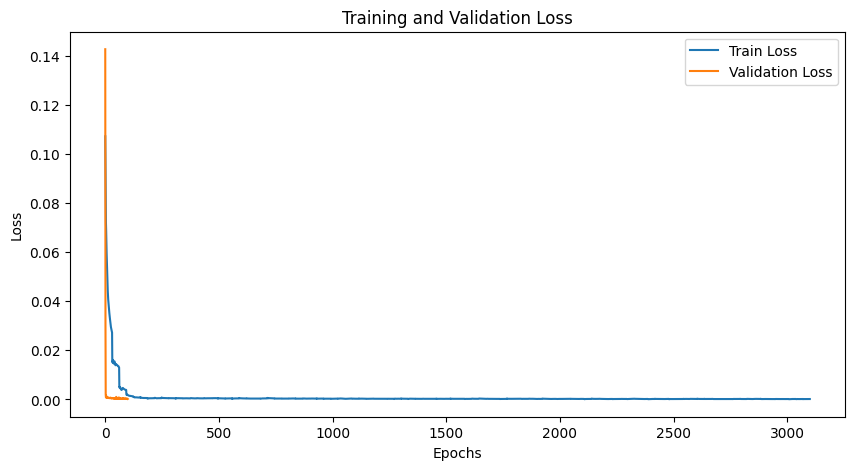

In [98]:
# 1. Vẽ đồ thị Loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Mở rộng: Add multi-step forecasting; compare CNN vs. LSTM.

In [99]:
# thêm tham số cấu hình thử nghiệm 
LOOK_BACK_EXT = 60 
FUTURE_STEPS_EXT = 5   # Số ngày dự báo trong tương lai (chỉ dùng cho 'multi')
FORECAST_TYPE_EXT = 'multi' # Lựa chọn: 'single' hoặc 'multi'
MODEL_CHOICE_EXT = 'CNNLSTM'  # Lựa chọn: 'LSTM', 'CNN', hoặc 'CNNLSTM'
EPOCHS_EXT = 100
BATCH_SIZE_EXT = 32


In [100]:
# tạo dữ liệu chuỗi thời gian mở rộng
def create_multi_step_sequences(data, look_back, future_steps):
    X, y = [], []
    for i in range(len(data) - look_back - future_steps + 1):
        X.append(data[i:(i + look_back), 0])
        y.append(data[(i + look_back):(i + look_back + future_steps), 0])
    return np.array(X), np.array(y)


In [101]:
# chuẩn bị dữ liệu cho mô hình mở rộng
if FORECAST_TYPE_EXT == 'single':
    output_size_ext = 1
    X_ext, y_ext = create_sequences(scaled_data, LOOK_BACK_EXT) 
else: # multi
    output_size_ext = FUTURE_STEPS_EXT
    X_ext, y_ext = create_multi_step_sequences(scaled_data, LOOK_BACK_EXT, FUTURE_STEPS_EXT)

total_sequences = len(X_ext)
train_size_ext = int(total_sequences * 0.70)
val_size_ext = int(total_sequences * 0.15)

X_train_ext, y_train_ext = X_ext[:train_size_ext], y_ext[:train_size_ext]
X_val_ext, y_val_ext = X_ext[train_size_ext : train_size_ext + val_size_ext], y_ext[train_size_ext : train_size_ext + val_size_ext]
X_test_ext, y_test_ext = X_ext[train_size_ext + val_size_ext:], y_ext[train_size_ext + val_size_ext:]

# Chuyển sang Tensor
X_train_tensor_ext = torch.from_numpy(X_train_ext).float().unsqueeze(-1)
y_train_tensor_ext = torch.from_numpy(y_train_ext).float()
X_val_tensor_ext = torch.from_numpy(X_val_ext).float().unsqueeze(-1) 
y_val_tensor_ext = torch.from_numpy(y_val_ext).float() 
X_test_tensor_ext = torch.from_numpy(X_test_ext).float().unsqueeze(-1)

if FORECAST_TYPE_EXT == 'single':
    y_train_tensor_ext = y_train_tensor_ext.unsqueeze(-1)
    y_val_tensor_ext = y_val_tensor_ext.unsqueeze(-1) 

train_dataset_ext = TensorDataset(X_train_tensor_ext, y_train_tensor_ext)
train_loader_ext = DataLoader(train_dataset_ext, batch_size=BATCH_SIZE_EXT, shuffle=True, drop_last=True)


In [102]:
# build lstm mở rộng
class LSTMModelExt(nn.Module):
    def __init__(self, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=2, batch_first=True, dropout=0.2)
        self.linear = nn.Linear(50, output_size)
    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

In [103]:
# build cnn
class CNNModelExt(nn.Module):
    def __init__(self, output_size=1, look_back=60):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        linear_input_size = 32 * (look_back - 5 + 1)
        self.linear1 = nn.Linear(linear_input_size, 50)
        self.linear2 = nn.Linear(50, output_size)
    def forward(self, input_seq):
        x = input_seq.permute(0, 2, 1)
        x = self.conv1(x); x = self.relu(x); x = self.flatten(x)
        x = self.linear1(x); x = self.relu(x)
        predictions = self.linear2(x)

In [104]:
# build mô hình lai cnn lstm
class CNNLSTMModelExt(nn.Module):
    def __init__(self, output_size=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=32, hidden_size=50, num_layers=2, batch_first=True, dropout=0.2)
        self.linear = nn.Linear(50, output_size)
    def forward(self, input_seq):
        x = input_seq.permute(0, 2, 1)
        x = self.conv1(x); x = self.relu(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        predictions = self.linear(x[:, -1, :])
        return predictions

In [105]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

if MODEL_CHOICE_EXT == 'LSTM':
    model_ext = LSTMModelExt(output_size=output_size_ext).to(device)
elif MODEL_CHOICE_EXT == 'CNN':
    model_ext = CNNModelExt(output_size=output_size_ext, look_back=LOOK_BACK_EXT).to(device)
elif MODEL_CHOICE_EXT == 'CNNLSTM':
    model_ext = CNNLSTMModelExt(output_size=output_size_ext).to(device)
else:
    raise ValueError("Lựa chọn model không hợp lệ.")

print(f"--- BẮT ĐẦU PHẦN MỞ RỘNG ---")
print(f"Đang chạy mô hình: {MODEL_CHOICE_EXT} cho dự báo {FORECAST_TYPE_EXT}-step")
print(model_ext)

criterion_ext = nn.MSELoss()
optimizer_ext = torch.optim.Adam(model_ext.parameters(), lr=0.001)

# Lists để lưu trữ lịch sử loss
train_losses_ext = []
val_losses_ext = []

# Chuyển dữ liệu validation sang device
X_val_tensor_ext = X_val_tensor_ext.to(device)
y_val_tensor_ext = y_val_tensor_ext.to(device)

print("\nBắt đầu huấn luyện...")
for epoch in range(EPOCHS_EXT):
    # Vòng lặp Train
    model_ext.train()
    batch_losses = []
    for seq, labels in train_loader_ext:
        seq, labels = seq.to(device), labels.to(device)
        optimizer_ext.zero_grad()
        y_pred = model_ext(seq)
        single_loss = criterion_ext(y_pred, labels)
        single_loss.backward()
        optimizer_ext.step()
        batch_losses.append(single_loss.item())
    
    train_loss = np.mean(batch_losses)
    train_losses_ext.append(train_loss)

    # Vòng lặp Validation
    model_ext.eval()
    with torch.no_grad():
        val_pred = model_ext(X_val_tensor_ext)
        val_loss = criterion_ext(val_pred, y_val_tensor_ext).item()
        val_losses_ext.append(val_loss)

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1:3d}/{EPOCHS_EXT}] | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

print("\n--- Huấn luyện phần mở rộng hoàn tất ---")

--- BẮT ĐẦU PHẦN MỞ RỘNG ---
Đang chạy mô hình: CNNLSTM cho dự báo multi-step
CNNLSTMModelExt(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,))
  (relu): ReLU()
  (lstm): LSTM(32, 50, num_layers=2, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=50, out_features=5, bias=True)
)

Bắt đầu huấn luyện...
Epoch [  1/100] | Train Loss: 0.048825 | Val Loss: 0.120409
Epoch [ 10/100] | Train Loss: 0.000795 | Val Loss: 0.001411
Epoch [ 20/100] | Train Loss: 0.000703 | Val Loss: 0.001600
Epoch [ 30/100] | Train Loss: 0.000670 | Val Loss: 0.000816
Epoch [ 40/100] | Train Loss: 0.000608 | Val Loss: 0.000736
Epoch [ 50/100] | Train Loss: 0.000558 | Val Loss: 0.001752
Epoch [ 60/100] | Train Loss: 0.000592 | Val Loss: 0.000695
Epoch [ 70/100] | Train Loss: 0.000515 | Val Loss: 0.001284
Epoch [ 80/100] | Train Loss: 0.000436 | Val Loss: 0.000613
Epoch [ 90/100] | Train Loss: 0.000438 | Val Loss: 0.000700
Epoch [100/100] | Train Loss: 0.000396 | Val Loss: 0.000552

--- Huấn luyện p

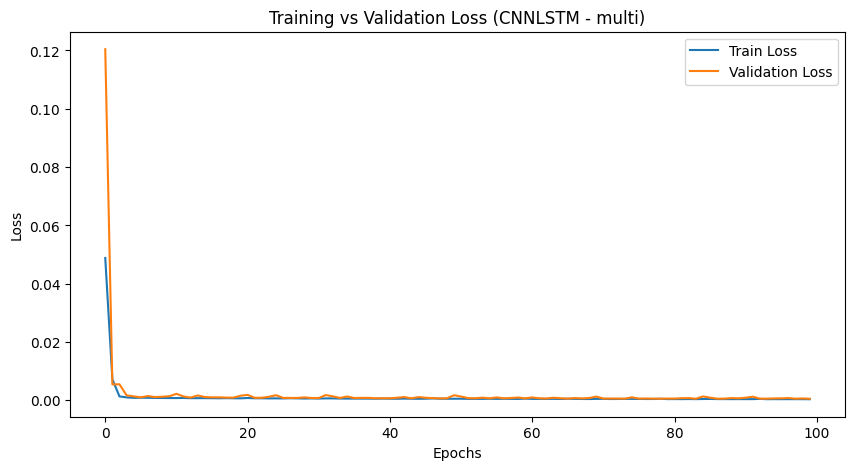

In [106]:
# Vẽ biểu đồ loss để kiểm tra overfitting
plt.figure(figsize=(10, 5))
plt.title(f"Training vs Validation Loss ({MODEL_CHOICE_EXT} - {FORECAST_TYPE_EXT})")
plt.plot(train_losses_ext, label="Train Loss")
plt.plot(val_losses_ext, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [107]:
# Đánh giá trên tập test 
model_ext.eval()
with torch.no_grad():
    test_pred_scaled = model_ext(X_test_tensor_ext.to(device)).cpu().numpy()

predictions_ext = scaler.inverse_transform(test_pred_scaled)
actuals_ext = scaler.inverse_transform(y_test_ext)

plot_predictions = predictions_ext[:, 0] if FORECAST_TYPE_EXT == 'multi' else predictions_ext.flatten()
plot_actuals = actuals_ext[:, 0] if FORECAST_TYPE_EXT == 'multi' else actuals_ext.flatten()

mae_ext = mean_absolute_error(plot_actuals, plot_predictions)
rmse_ext = np.sqrt(mean_squared_error(plot_actuals, plot_predictions))
r2_ext = r2_score(plot_actuals, plot_predictions)
print(f"\\n--- KẾT QUẢ ĐÁNH GIÁ PHẦN MỞ RỘNG ({MODEL_CHOICE_EXT} - {FORECAST_TYPE_EXT}) ---")
print(f"MAE = {mae_ext:.2f}")
print(f"RMSE = {rmse_ext:.2f}")
print(f"R² = {r2_ext:.3f}")

\n--- KẾT QUẢ ĐÁNH GIÁ PHẦN MỞ RỘNG (CNNLSTM - multi) ---
MAE = 19.87
RMSE = 23.56
R² = 0.810


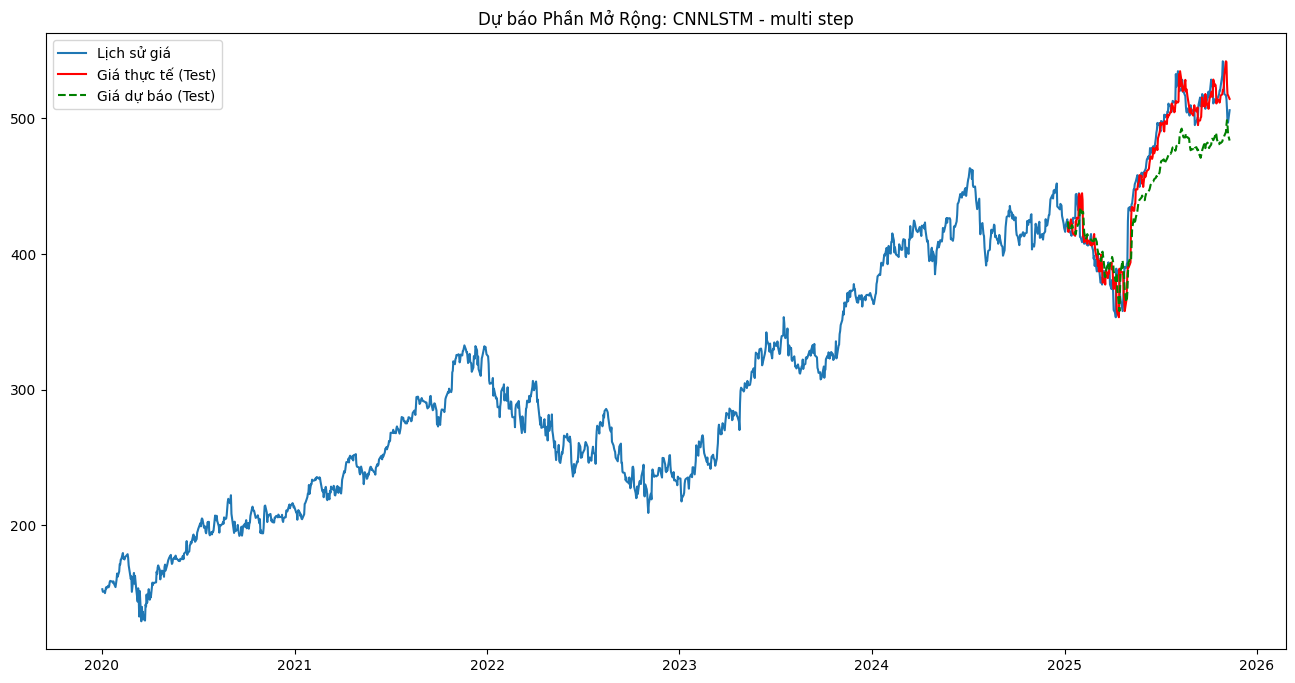

In [108]:
# Trực quan hóa dự báo 
plt.figure(figsize=(16, 8))
plt.title(f'Dự báo Phần Mở Rộng: {MODEL_CHOICE_EXT} - {FORECAST_TYPE_EXT} step')
test_start_index = len(data) - len(plot_actuals)
plt.plot(data.index, data['Close'], label='Lịch sử giá')
plt.plot(data.index[test_start_index:], plot_actuals, label='Giá thực tế (Test)', color='red')
plt.plot(data.index[test_start_index:], plot_predictions, label='Giá dự báo (Test)', color='green', linestyle='--')
plt.legend()
plt.show()

In [109]:
# In ra dự báo tương lai
if FORECAST_TYPE_EXT == 'multi':
    # Lấy 60 ngày cuối cùng của toàn bộ dữ liệu
    last_60_days_scaled = scaled_data[-LOOK_BACK_EXT:]
    last_60_days_tensor = torch.from_numpy(last_60_days_scaled).float().unsqueeze(0).to(device)
    
    # Dự báo
    model_ext.eval()
    with torch.no_grad():
        future_preds_scaled = model_ext(last_60_days_tensor).cpu().numpy()

    # Đảo ngược scale
    future_predictions = scaler.inverse_transform(future_preds_scaled).flatten()
    
    print(f"\\n--- Dự báo cho {FUTURE_STEPS_EXT} ngày tiếp theo (tính từ {data.index[-1].date()}) ---")
    for i, pred in enumerate(future_predictions):
        print(f"Ngày +{i+1}: {pred:.2f}")

\n--- Dự báo cho 5 ngày tiếp theo (tính từ 2025-11-10) ---
Ngày +1: 474.10
Ngày +2: 478.08
Ngày +3: 472.25
Ngày +4: 477.31
Ngày +5: 480.97
